## Basic Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from loss_optimization.accuracy_score import encode_y

import time
seed = 100

In [2]:
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp, PauliList

from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit_algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals



## Data Loading

In [3]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.668720,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.409180,-2.094395,0
2,-0.184800,2.636412,0.154505,-3.141593,-3.141593,-0.959801,-1.547992,-1.989675,1
3,-2.771994,-0.331525,0.257508,-1.681863,-2.443461,-0.510333,-2.902821,-3.141593,0
4,-3.141593,1.184017,-1.081532,-0.920265,-1.893868,0.894254,2.787459,-1.884956,1


In [4]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)





In [5]:
# split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [6]:
x_train.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
425,-1.663196,2.667986,0.875526,-0.666398,-1.084332,0.323055,-2.642586,-2.094395
455,2.032795,2.383822,0.051502,-1.237597,-3.141593,0.004682,-2.782094,-1.361357
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.668720,-0.104720
557,-0.184800,0.331525,0.772523,-3.141593,-3.141593,-0.538425,-2.715023,0.733038
378,-1.663196,1.783919,0.721021,-3.141593,-3.141593,1.381177,-2.712340,-1.989675


In [7]:
y_train.head(5)

425    1
455    1
0      1
557    0
378    1
Name: Outcome, dtype: int64

In [8]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]

In [9]:
x_train_A.head(5)


,Pregnancies,Glucose,BloodPressure,SkinThickness
425,-1.663196,2.667986,0.875526,-0.666398
455,2.032795,2.383822,0.051502,-1.237597
0,-0.923998,1.531329,0.566517,-0.920265
557,-0.184800,0.331525,0.772523,-3.141593
378,-1.663196,1.783919,0.721021,-3.141593


In [10]:
x_train_B.head(5)

,Insulin,BMI,DiabetesPedigreeFunction,Age
425,-1.084332,0.323055,-2.642586,-2.094395
455,-3.141593,0.004682,-2.782094,-1.361357
0,-3.141593,0.004682,-1.668720,-0.104720
557,-3.141593,-0.538425,-2.715023,0.733038
378,-3.141593,1.381177,-2.712340,-1.989675


In [11]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [12]:
new_y_train = encode_y(y_train)
new_y_test = encode_y(y_test)

## Data Embedding

In [13]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)                # Create a quantum circuit
    feature_param = ParameterVector("Theta", feature_dims)  # Create a list of parameters
    for qubit in range(feature_dims):                       # Rotate each qubit by the corresponding angle
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [14]:
embedding, feature_params = angle_encoding(4)               # Create an angle encoding circuit for 4 features

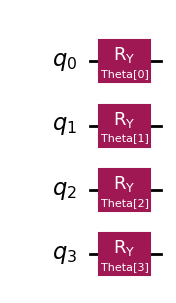

In [15]:
embedding.draw(output='mpl',style='iqx')

In [16]:
print(feature_params)

Theta, ['Theta[0]', 'Theta[1]', 'Theta[2]', 'Theta[3]']


## Tensor Network

In [17]:
from tensor_network.ttn import TTN

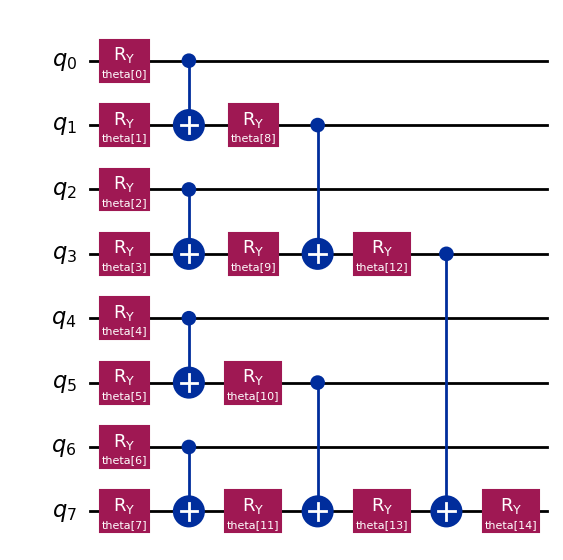

In [18]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

## Circuit Cutting

#### Find the Best Possible Cut

In [19]:
from circuit_knitting.cutting import partition_problem
from circuit_knitting.cutting.cut_finding.cco_utils import qc_to_cco_circuit
circuit_ckt = qc_to_cco_circuit(ttn)

In [20]:
from qiskit.quantum_info import PauliList
import numpy as np
from circuit_knitting.cutting.cut_finding.circuit_interface import SimpleGateList
from circuit_knitting.cutting.cut_finding.lo_cuts_optimizer import LOCutsOptimizer
from circuit_knitting.cutting.cut_finding.optimization_settings import (
    OptimizationSettings,
)
from circuit_knitting.cutting.cut_finding.quantum_device_constraints import (
    DeviceConstraints,
)

In [21]:
settings = OptimizationSettings(seed=12345)

settings.set_engine_selection("CutOptimization", "BestFirst")


qubits_per_qpu = 4


for qubits_per_qpu in range(qubits_per_qpu, 1, -1):
    print(f"\n\n---------- {qubits_per_qpu} Qubits per QPU ----------")

    constraint_obj = DeviceConstraints(qubits_per_qpu=qubits_per_qpu)
    interface = SimpleGateList(circuit_ckt)

    op = LOCutsOptimizer(interface, settings, constraint_obj)

    out = op.optimize()

    print(
        " Gamma =",
        None if (out is None) else out.upper_bound_gamma(),
        ", Min_gamma_reached =",
        op.minimum_reached(),
    )
    if out is not None:
        out.print(simple=True)
    else:
        print(out)

    print(
        "Subcircuits:",
        interface.export_subcircuits_as_string(name_mapping="default"),
        "\n",
    )



---------- 4 Qubits per QPU ----------
 Gamma = 3.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=20, gate_name='cx', qubits=[3, 7]))]
Subcircuits: AAAABBBB 



---------- 3 Qubits per QPU ----------
 Gamma = 27.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=5, gate_name='cx', qubits=[2, 3])), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=8, gate_name='cx', qubits=[4, 5])), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=20, gate_name='cx', qubits=[3, 7]))]
Subcircuits: AABACDDD 



---------- 2 Qubits per QPU ----------
 Gamma = 27.0 , Min_gamma_reached = True
[CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_location=GateCutLocation(instruction_id=14, gate_name='cx', qubits=[1, 3])), CutIdentifier(cut_action='CutTwoQubitGate', gate_cut_loc

The first cut has the minimum $\gamma$, so we will go by that partioning 

Found solution using 1 cuts with a sampling overhead of 9.0.
Gate Cut at index 20


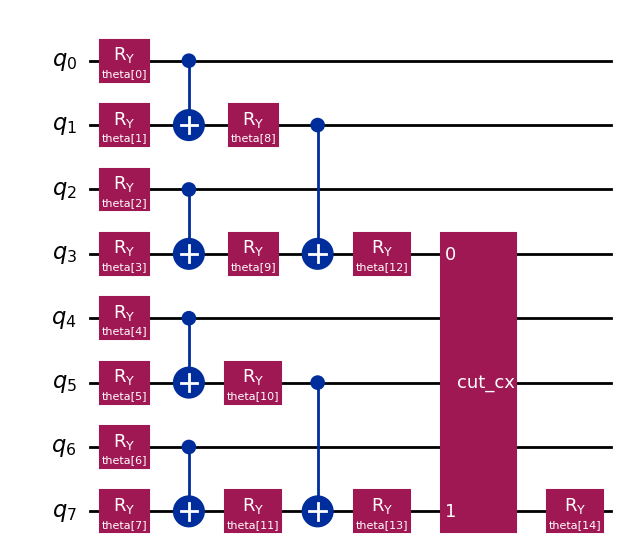

In [22]:
from circuit_knitting.cutting import (
    OptimizationParameters,
    DeviceConstraints,
    find_cuts,
)

# Specify settings for the cut-finding optimizer
optimization_settings = OptimizationParameters(seed=111)

# Specify the size of the QPUs available
device_constraints = DeviceConstraints(qubits_per_qpu=6)

cut_circuit, metadata = find_cuts(ttn, optimization_settings, device_constraints)
print(
    f'Found solution using {len(metadata["cuts"])} cuts with a sampling '
    f'overhead of {metadata["sampling_overhead"]}.'
)
for cut in metadata["cuts"]:
    print(f"{cut[0]} at index {cut[1]}")
cut_circuit.draw("mpl",style='iqp')

In [23]:
observables = PauliList(["ZIIIIIII"])

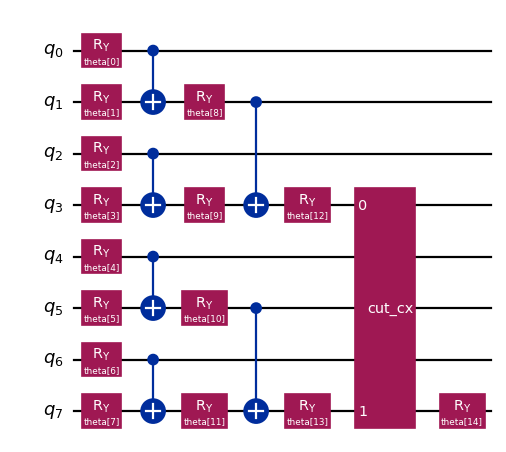

In [24]:
from circuit_knitting.cutting import cut_wires, expand_observables

qc_w_ancilla = cut_wires(cut_circuit)
observables_expanded = expand_observables(observables, ttn, qc_w_ancilla)
qc_w_ancilla.draw("mpl", scale=0.8, fold=-1,style='iqp')

In [25]:
partitioned_problem = partition_problem(circuit=qc_w_ancilla, partition_labels="AAAABBBB", observables=observables_expanded)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [26]:
sub_observables

{'A': PauliList(['IIII']), 'B': PauliList(['ZIII'])}

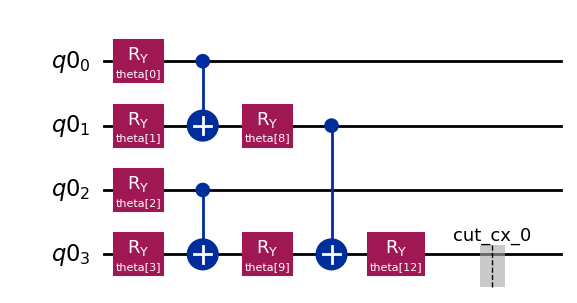

In [27]:
sub_circuits["A"].draw("mpl", style="iqp")

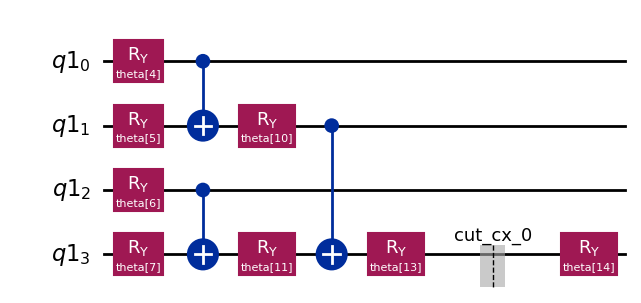

In [28]:
sub_circuits["B"].draw("mpl", style="iqp")

In [29]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 9.0


### Sub Experiments

In [30]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

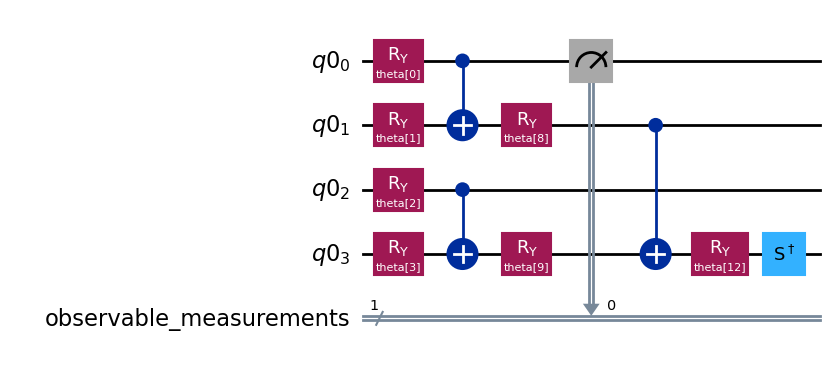

In [31]:
subexperiments["A"][0].draw("mpl", style="iqp")  # measurement on first qubit

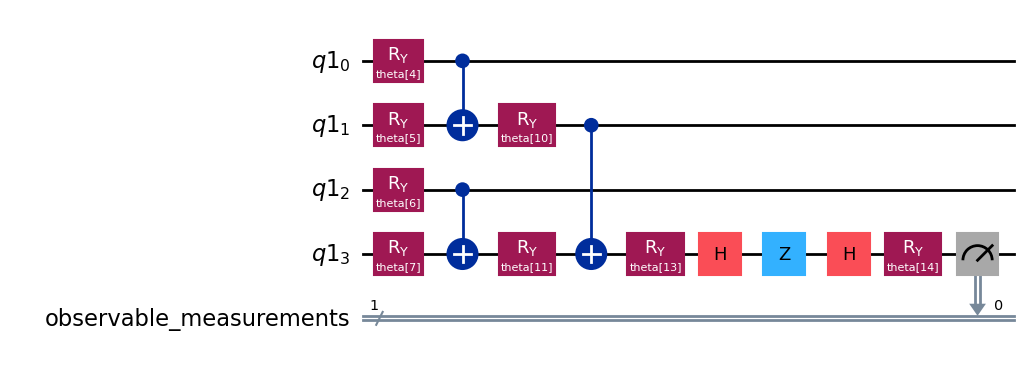

In [32]:
subexperiments["B"][3].draw("mpl", style="iqp")  # measurement on last qubit

## Neural Network Training

In [33]:
from qiskit_machine_learning.neural_networks import SamplerQNN, NeuralNetwork
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from typing import Callable

In [34]:
# from qiskit_ibm_provider import IBMProvider
# provider = IBMProvider()
# qasm_backend = provider.get_backend("ibmq_qasm_simulator")

In [35]:
sim = AerSimulator(method="automatic")

In [36]:
sampler = Sampler(backend_options={"simulator": sim}, transpile_options={"optimization_level": 3})
#sampler = Sampler(backend_options={"simulator": sim})

### Sampler

In [37]:
from primitives.custom_sampler_qnn import CustomSampler

#### For subexperiments["A"]

In [38]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [39]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
    input_gradients=False,
)

In [40]:
weights_A = algorithm_globals.random.random(7)
forward_output = sampler_qcnn.forward(
    input_data=x_train_A,
    weights=weights_A,
)

Running Time for Forward Pass: %s seconds 4.15294075012207


In [41]:
# forward output is a dictionary of 6 subex_circ items.
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(len(forward_output[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.44042969 0.55957031 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.49023438 0.50976562 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.34667969 0.390625   0.15332031 0.109375   0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.32324219 0.41894531 0.13574219 0.12207031 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.46972656 0.53027344 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.48242188 0.51757812 0.         0.         0.         0.
  0.         0.

In [42]:
input_grad, weights_grad = sampler_qcnn.backward(
    input_data=x_train_A,
    weights=weights_A
)

Running Time for Backward Pass: %s seconds 91.72777128219604


In [43]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 7)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[ 0.95800781  0.          0.          0.          0.
    0.          0.        ]
  [-0.95800781  0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.      

#### For subexperiments["B"]

In [44]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [45]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits2, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [46]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn2._forward(
    input_data=x_train_B,
    weights=weights_B,
)

Running Time for Forward Pass: %s seconds 6.09309983253479


In [47]:
print(f"Output shape for {len(x_train_A)} samples: {forward_output2[0].shape}")
print(len(forward_output2[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output2[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.57226562 0.42773438 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.58886719 0.41113281 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.81933594 0.18066406 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.33496094 0.66503906 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07226562 0.12304688 0.50488281 0.29980469 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.07519531 0.13476562 0.48046875 0.30957031 0.         0.
  0.         0.

In [48]:
input_grad2, weights_grad2 = sampler_qcnn2._backward(
    input_data=x_train_B,
    weights=weights_B
)

Running Time for Backward Pass: %s seconds 153.83654761314392


In [49]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad2[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad2[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 8)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[ 0.24365234  0.          0.          0.          0.
    0.          0.          0.        ]
  [-0.24365234  0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.          0.        ]
  [ 0.          0.     

## Loss and Optimization

In [50]:
from qiskit_machine_learning.utils.loss_functions import L2Loss
from loss_optimization.custom_cross_entropy_loss import CustomCrossEntropyLoss
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from loss_optimization.objective_func import CustomMultiClassObjectiveFunction
# from loss_optimization.callback import callback
from loss_optimization.optimization import create_objective, minimizer, print_optimizer_results

In [51]:
def callback_spsa(nfev=None, params=None, fval=None, stepsize=None, accepted=None):
    """
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    # objective_func_vals = loss
    global objective_func_vals

    if (nfev % 3) == 0:
        objective_func_vals.append(fval)
        print(f"SPSA Epoch {len(objective_func_vals)}: {fval:.5f}")

def callback_cobyla(weights, obj_func_eval):
    # clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print(f"COBYLA Epoch {len(objective_func_vals)}: {obj_func_eval:.5f}")

In [52]:
objective_func_vals = []
# loss = L2Loss()
loss = CustomCrossEntropyLoss()
# optimizer = COBYLA(maxiter=5)
optimizer = SPSA(maxiter=50, callback=callback_spsa)
# optimizer = GradientDescent(maxiter=2) # This doesn't work yet. The gradient shape doesn't match.

#### Optimizer Result for sub-circuits["A"]

In [53]:
initial_point = np.random.random((7,))
function = CustomMultiClassObjectiveFunction(x_train_A, y_train, sampler_qcnn, loss)

In [54]:
# Optimizer result for 0th circuit for sub-circuit-A
start_time = time.time()
optimizer_result_A0 = minimizer(function, function.objective0, function.gradient0, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A1: %s seconds", running_time)

start_time = time.time()
optimizer_result_A1 = minimizer(function, function.objective1, function.gradient1, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A2: %s seconds", running_time)

start_time = time.time()
optimizer_result_A2 = minimizer(function, function.objective2, function.gradient2, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A3: %s seconds", running_time)

start_time = time.time()
optimizer_result_A3 = minimizer(function, function.objective3, function.gradient3, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A4: %s seconds", running_time)

start_time = time.time()
optimizer_result_A4 = minimizer(function, function.objective4, function.gradient4, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A5: %s seconds", running_time)

start_time = time.time()
optimizer_result_A5 = minimizer(function, function.objective5, function.gradient5, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A6: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 3.631956100463867
Running Time for Forward Pass: %s seconds 3.7535815238952637
Running Time for Forward Pass: %s seconds 3.7008421421051025
Running Time for Forward Pass: %s seconds 3.586787700653076
Running Time for Forward Pass: %s seconds 3.6863341331481934
Running Time for Forward Pass: %s seconds 3.603281021118164
Running Time for Forward Pass: %s seconds 3.6696505546569824
Running Time for Forward Pass: %s seconds 3.6768290996551514
Running Time for Forward Pass: %s seconds 3.558980703353882
Running Time for Forward Pass: %s seconds 3.686480760574341
Running Time for Forward Pass: %s seconds 3.593966007232666
Running Time for Forward Pass: %s seconds 3.6616413593292236
Running Time for Forward Pass: %s seconds 3.6348869800567627
Running Time for Forward Pass: %s seconds 3.7029318809509277
Running Time for Forward Pass: %s seconds 3.6389176845550537
Running Time for Forward Pass: %s seconds 3.662440776824951
Running Time for Forward Pass: 

In [55]:
optimizer_results_A = [optimizer_result_A0, optimizer_result_A1, optimizer_result_A2, optimizer_result_A3, optimizer_result_A4, optimizer_result_A5]

In [56]:
# Print results from 6 sub-experiments of sub-circuit-A
for opt_result in optimizer_results_A:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [-1.06177824  1.11783538  0.1560531   0.66267311 -0.73650219  0.91631755
  0.52189187]
The final value of the minimization: 2.883319232872014
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-1.0659967  -0.31302655 -0.42375999  0.99821424  1.0308115   0.73370598
 -0.13553364]
The final value of the minimization: 2.865543213364678
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-1.1205032  -0.8749712  -0.18412782  0.46192326  0.22252652 -0.32520469
 -1.49771865]
The final value of the minimization: 0.3311538116862398
The final gradient of the minimization: None
The total number of function eva

Text(0.5, 1.0, 'Training loss')

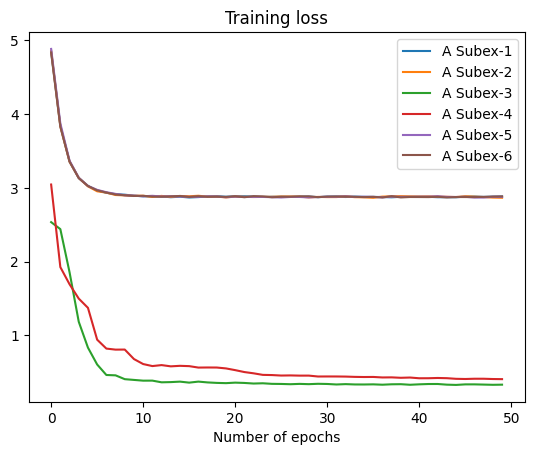

In [57]:
plt.plot(objective_func_vals[:50], label="A Subex-1")
plt.plot(objective_func_vals[50:100], label="A Subex-2")
plt.plot(objective_func_vals[100:150], label="A Subex-3")
plt.plot(objective_func_vals[150:200], label="A Subex-4")
plt.plot(objective_func_vals[200:250], label="A Subex-5")
plt.plot(objective_func_vals[250:300], label="A Subex-6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [58]:
objective_func_vals.clear()
objective_func_vals

[]

#### Optimizer Result for sub-circuits["B"]

In [59]:
initial_point2 = np.random.random((8,))
function2 = CustomMultiClassObjectiveFunction(x_train_B, y_train, sampler_qcnn2, loss)

In [60]:
# Optimizer result for 0th circuit for sub-circuit-B
start_time = time.time()
optimizer_result_B0 = minimizer(function2, function2.objective0, function2.gradient0, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B1 = minimizer(function2, function2.objective1, function2.gradient1, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B2: %s seconds", running_time)

start_time = time.time()
optimizer_result_B2 = minimizer(function2, function2.objective2, function2.gradient2, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B3: %s seconds", running_time)

start_time = time.time()
optimizer_result_B3 = minimizer(function2, function2.objective3, function2.gradient3, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B4: %s seconds", running_time)

start_time = time.time()
optimizer_result_B4 = minimizer(function2, function2.objective4, function2.gradient4, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B5: %s seconds", running_time)

start_time = time.time()
optimizer_result_B5 = minimizer(function2, function2.objective5, function2.gradient5, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B6: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 6.180798292160034
Running Time for Forward Pass: %s seconds 6.24158787727356
Running Time for Forward Pass: %s seconds 6.069637060165405
Running Time for Forward Pass: %s seconds 6.2216761112213135
Running Time for Forward Pass: %s seconds 6.121692657470703
Running Time for Forward Pass: %s seconds 6.124650716781616
Running Time for Forward Pass: %s seconds 6.085435390472412
Running Time for Forward Pass: %s seconds 6.105200529098511
Running Time for Forward Pass: %s seconds 6.1881866455078125
Running Time for Forward Pass: %s seconds 6.188478469848633
Running Time for Forward Pass: %s seconds 6.124386548995972
Running Time for Forward Pass: %s seconds 6.205027103424072
Running Time for Forward Pass: %s seconds 6.230199813842773
Running Time for Forward Pass: %s seconds 6.088452100753784
Running Time for Forward Pass: %s seconds 6.188639879226685
Running Time for Forward Pass: %s seconds 6.121535301208496
Running Time for Forward Pass: %s secon

In [61]:
optimizer_results_B = [optimizer_result_B0, optimizer_result_B1, optimizer_result_B2, optimizer_result_B3, optimizer_result_B4, optimizer_result_B5]

In [62]:
# Print results from 6 sub-experiments of sub-circuit-B
for opt_result in optimizer_results_B:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [ 0.5779459   0.99448741 -0.35299455  0.57403537  1.28321354 -0.39039841
  2.83296407  1.62982623]
The final value of the minimization: 2.7602920738074985
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [ 0.91700215  1.09763774  2.13497584  0.20137532 -0.68356236  0.51206975
 -0.06511074 -1.61075338]
The final value of the minimization: 2.8315794097699065
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-0.62993588 -0.44859905 -0.85055665 -1.81714738  1.86660275  0.71412095
  1.36623046  0.00200395]
The final value of the minimization: 3.0169346280691935
The final gradient of the minimization:

Text(0.5, 1.0, 'Training loss')

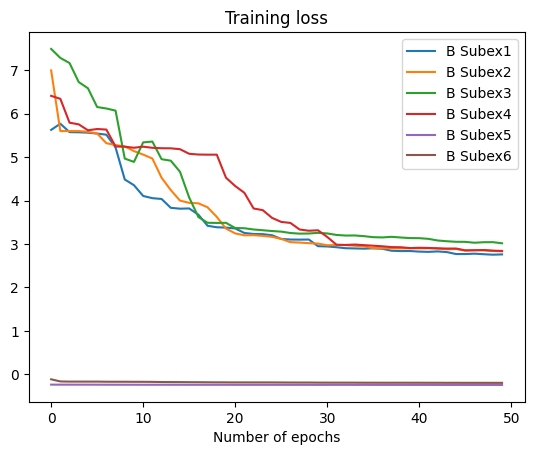

In [63]:
plt.plot(objective_func_vals[:50], label="B Subex1")
plt.plot(objective_func_vals[50:100], label="B Subex2")
plt.plot(objective_func_vals[100:150], label="B Subex3")
plt.plot(objective_func_vals[150:200], label="B Subex4")
plt.plot(objective_func_vals[200:250], label="B Subex5")
plt.plot(objective_func_vals[250:300], label="B Subex6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [64]:
objective_func_vals.clear()
objective_func_vals

[]

### At this point, the training is complete. 
We have 12 lists of 7 or 8 parameter values that will now be used to make predictions on the test cases. 
New subcircuits will be built using these parameter values and then their results will be used to reconstruct expectation values. This process will occur for all the inputs in the test set.


Let us think of the training process as a box that we can tune/edit while training on the train set. However, once the training process is complete, the box is locked and provided to the user. The user can now send test data to the box and get its desired output.

However, in the case of circuit cutting, instead of having one box, we have multiple boxes. In our case, we have a total of 12 boxes (6 boxes per cut). These 12 boxes are trained independently of each other and locked after the training process is complete. The user, now, instead of sending the test data to one box, splits it into 2 parts that are sent to these 12 boxes. The 12 boxes produce quasi-probability distributions respective to the circuits they implement which are then reconstructed to produce the expectation value according to the test input. This process is repeated for every data point in the test dataset.

## Reconstruct Expectation Values and Testing

In [65]:
from circuit_knitting.cutting import reconstruct_expectation_values
from qiskit_aer.primitives import Sampler
from qiskit.primitives import SamplerResult
from loss_optimization.accuracy_score import get_accuracy_score, predict
from circuit_cut.reconstruct_exp_val import get_subcircuit_results, get_dict_sampler_results, get_reconstructed_expvals

### Reconstructing for train accuracy

In [66]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [67]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [68]:
train_results_A = get_subcircuit_results(x_train_A, final_circuits, optimizer_results_A, sampler)
train_results_B = get_subcircuit_results(x_train_B, final_circuits2, optimizer_results_B, sampler)

In [69]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 537 train data inputs
A_dict = get_dict_sampler_results(x_train_A, subexperiments["A"], train_results_A)
B_dict = get_dict_sampler_results(x_train_B, subexperiments["B"], train_results_B)

In [70]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [71]:
y_predicted = predict(reconstructed_expvals)

In [72]:
# accuracy_score function encodes y_train inside the function. Therefore, pass original y_train here.
train_score1 = get_accuracy_score(new_y_train, y_predicted)
train_score2 = get_accuracy_score(y_train, y_predicted)
print(f"The Train Accuracy of the model is: {train_score1, train_score2}")

The Train Accuracy of the model is: (0.659217877094972, 0.659217877094972)


### Reconstructing for test accuracy

In [73]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [74]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [75]:
test_results_A = get_subcircuit_results(x_test_A, final_circuits, optimizer_results_A, sampler)
test_results_B = get_subcircuit_results(x_test_B, final_circuits2, optimizer_results_B, sampler)

In [76]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 231 test data inputs
A_dict = get_dict_sampler_results(x_test_A, subexperiments["A"], test_results_A)
B_dict = get_dict_sampler_results(x_test_B, subexperiments["B"], test_results_B)

In [77]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [78]:
y_predicted = predict(reconstructed_expvals)

In [79]:
# Pass original y_test here.
test_score1 = get_accuracy_score(new_y_test, y_predicted)
test_score2 = get_accuracy_score(y_test, y_predicted)
print(f"The Test Accuracy of the model is: {test_score1, test_score2}")

The Test Accuracy of the model is: (0.6147186147186147, 0.6147186147186147)


In [80]:
# brand_new_y_train = new_y_train.replace({-1: 1, 1: -1})
# brand_new_y_test = new_y_test.replace({-1: 1, 1: -1})

## Test original circuit for x_test[0]

In [81]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendEstimator
from qiskit_aer.primitives import Estimator
from qiskit_aer import AerSimulator
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

In [82]:
embedding, features = angle_encoding(8)
new_ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
org_circuit = embedding.compose(new_ttn)
# final_circuit.draw()

In [83]:
# gpu_simulator = AerSimulator(device='GPU')
simulator = AerSimulator()
backend = Estimator(backend_options={"simulator": simulator}, transpile_options={"optimization_level": 3})

In [84]:
# loss = L2Loss()
loss = CrossEntropyLoss()
# optimizer = COBYLA(maxiter=5)
# optimizer = SPSA(maxiter=5, callback=callback_spsa)

In [85]:
observable = SparsePauliOp(["ZIIIIIII"])
estimator_qnn = EstimatorQNN(
    estimator=backend,
    circuit=org_circuit,
    observables=observable,
    input_params=features.params,
    weight_params=new_ttn.parameters,
)

In [86]:
weights = np.random.random(len(new_ttn.parameters))

In [87]:
# Forward pass
output = estimator_qnn.forward(x_train, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 768 samples: (537, 1)
Output of the forward pass for first sample: [0.48632812]


In [88]:
# Backward pass
_, weights_grad = estimator_qnn.backward(x_train, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

Output shape for 768 samples: (537, 1, 15)
Output of the backward pass for first sample: [[ 0.02050781 -0.0234375   0.36523438  0.04589844 -0.01367188  0.02246094
  -0.00488281  0.16796875 -0.02734375 -0.02539062  0.03222656 -0.20117188
   0.015625   -0.21582031  0.63574219]]


In [89]:
initial_point = np.random.random((len(new_ttn.parameters),))

In [90]:
objective_func_vals = []
classifier = NeuralNetworkClassifier(
    estimator_qnn,
    optimizer=SPSA(maxiter=50, callback=callback_spsa),
    loss=loss,
    # optimizer=COBYLA(maxiter=10),
    initial_point=initial_point,
)

In [91]:
print(len(x_test.values), len(new_y_test.values))

231 231


In [92]:
start_time = time.time()
classifier.fit(x_train, new_y_train.values)
end_time = time.time()
running_time = end_time - start_time
print("Running Time%s seconds", running_time)

SPSA Epoch 1: -0.70315
SPSA Epoch 2: -1.68589
SPSA Epoch 3: -4.37167
SPSA Epoch 4: -4.77374
SPSA Epoch 5: -5.75607
SPSA Epoch 6: -11.36814
SPSA Epoch 7: -11.20215
SPSA Epoch 8: -11.23805
SPSA Epoch 9: -11.33375
SPSA Epoch 10: -11.31069
SPSA Epoch 11: -11.63021
SPSA Epoch 12: -11.52787
SPSA Epoch 13: -11.50514
SPSA Epoch 14: -11.42606
SPSA Epoch 15: -11.49862
SPSA Epoch 16: -11.47161
SPSA Epoch 17: -11.69567
SPSA Epoch 18: -11.65958
SPSA Epoch 19: -11.60270
SPSA Epoch 20: -11.50048
SPSA Epoch 21: -11.49309
SPSA Epoch 22: -11.51114
SPSA Epoch 23: -11.76027
SPSA Epoch 24: -11.77968
SPSA Epoch 25: -11.66349
SPSA Epoch 26: -11.55241
SPSA Epoch 27: -11.66413
SPSA Epoch 28: -11.60920
SPSA Epoch 29: -11.39498
SPSA Epoch 30: -11.80154
SPSA Epoch 31: -11.55193
SPSA Epoch 32: -11.65980
SPSA Epoch 33: -11.78061
SPSA Epoch 34: -12.15079
SPSA Epoch 35: -12.00716
SPSA Epoch 36: -12.05006
SPSA Epoch 37: -11.92858
SPSA Epoch 38: -11.82961
SPSA Epoch 39: -11.93993
SPSA Epoch 40: -11.76051
SPSA Epoch 41:

Text(0.5, 1.0, 'Training loss')

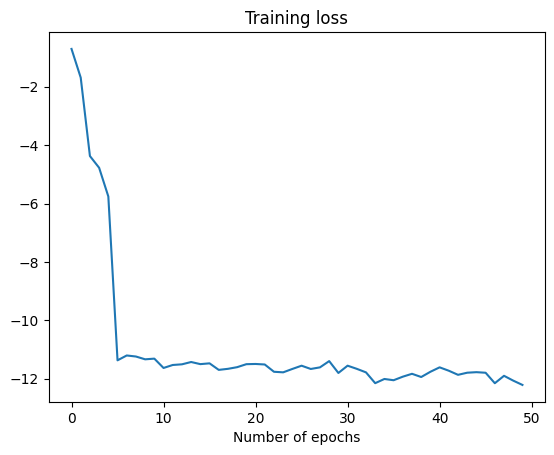

In [93]:
plt.plot(objective_func_vals)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [94]:
y_test_pred = classifier.predict(x_test)
# y_test_pred

In [95]:
classifier.score(x_train, new_y_train)

0.6983240223463687

In [96]:
classifier.score(x_test, new_y_test)

0.658008658008658